# Trying a tokenized autoencoder

E.g. from IRIS https://github.dev/eloialonso/iris where sparsity is enforced by the tokenization/embedding quantisation bottleneck

In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm


from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoConfig,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    LoftQConfig,
    IA3Config,
)
from pathlib import Path
import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl

from src.config import ExtractConfig
from src.llms.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.llms.phi.model_phi import PhiForCausalLMWHS
from src.eval.ds import filter_ds_to_known
from src.datasets.act_dm import ActivationDataModule

# plt.style.use("ggplot")
# plt.style.use("seaborn-v0_8")
import seaborn as sns


sns.set_theme("paper")

plt.rcParams["figure.figsize"] = (4, 3)

In [ ]:
import logging
import warnings

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings(
    "ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*"
)
# warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")

In [ ]:
os.environ["TQDM_MININTERVAL"] = "9"
# os.environ["TQDM_DISABLE"] = "1"

verbose = False

## Paramsnet


In [ ]:
# params
# params
batch_size = 32
lr = 4e-3
wd = 0  # 1e-5

MAX_ROWS = 2000

SKIP = 15  # skip initial N layers
STRIDE = 3  # skip every N layers
DECIMATE = 1  # discard N features for speed

device = "cuda:0"
max_epochs = 84

l1_coeff = 1e-2  # 0.5  # neel uses 3e-4 ! https://github.dev/neelnanda-io/1L-Sparse-Autoencoder/blob/bcae01328a2f41d24bd4a9160828f2fc22737f75/utils.py#L106, but them they sum l1 where mean l2
# x_feats=x_feats. other use 1e-1
# in ai saftey foundation. They use l1_coefficient=Parameter(max=0.03, min=0.008),


BASE_FOLDER = Path(
    "/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/"
)
layers_names = ("fc1", "Wqkv",
                #  "fc2", "out_proj"
                 )

## Load data

In [ ]:
# load hidden state from a previously loaded adapter
# the columns with _base are from the base model, and adapt from adapter
# FROM TRAINING TRUTH
f1_val = next(iter(BASE_FOLDER.glob("hidden_states/.ds/ds_valtest_*")))
f1_ood = next(iter(BASE_FOLDER.glob("hidden_states/.ds/ds_OOD_*")))
f1_val, f1_ood

In [ ]:
input_columns = (
    ["binary_ans_base", "binary_ans_adapt"]
    + [f"end_residual_{layer}_base" for layer in layers_names]
    + [f"end_residual_{layer}_adapt" for layer in layers_names]
)


def ds2xy_batched(ds):
    data = []
    for layer in layers_names:
        # Stack the base and adapter representations as a 4th dim
        X1 = [ds[f"end_residual_{layer}_base"], ds[f"end_residual_{layer}_adapt"]]
        X1 = rearrange(X1, "versions b l f  -> b l f versions")[..., 0]
        data.append(X1)

    # concat layers
    # x = rearrange(data, 'b parts l f v -> b l (parts f) v')
    X = torch.concat(data, dim=2)[:, SKIP::STRIDE, ::DECIMATE]

    y = ds["binary_ans_base"] - ds["binary_ans_adapt"]
    return dict(X=X, y=y)


def prepare_ds(ds):
    """
    prepare a dataset for training

    this should front load much of the computation
    it should restrict it to the needed rows X and y

    """
    ds = (
        ds.with_format("torch")
        .select_columns(input_columns)
        .map(ds2xy_batched, batched=True, batch_size=128, remove_columns=input_columns)
    )
    return ds


def load_file_to_dm(f, stage):
    ds1 = Dataset.from_file(str(f1_val), in_memory=True).with_format("torch")
    ds1 = filter_ds_to_known(ds1, verbose=True, true_col="truth")
    ds = prepare_ds(ds1)

    # limit size
    MAX_SAMPLES = min(len(ds), MAX_ROWS * 2)
    ds = ds.select(range(0, MAX_SAMPLES))

    dm = ActivationDataModule(ds, f.stem, batch_size=batch_size, num_workers=0)
    dm.setup(stage)
    dm.dm_orig = ds1
    return dm


dm = load_file_to_dm(f1_val, "train")
dm_ood = load_file_to_dm(f1_ood, "all")

In [ ]:
dm_ood.datasets

In [ ]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
dl_test = dm.test_dataloader()
dl_ood = dm_ood.all_dataloader()

Experiment with dataloading speeds:
- does it help to save the Xy dataset to disc, then load, while keeping in mem?. no not faster at all
- does it help to use num_workers > 0? yes 3x faster
- the shared dataset wrapper is 10x faster, and less mem

# Get importance matrix from adapter

In [ ]:
from src.probes.importance_matrix import get_importance_matrix


f = f"{BASE_FOLDER}/checkpoint_last/adapter_model.safetensors"
importance_matrix = get_importance_matrix(f, layers=layers_names)[
    SKIP::STRIDE, ::DECIMATE
]


# importance_matrix = importance_matrix ** 3 # square to make it positive
importance_matrix = (importance_matrix - 1).abs() ** 2


# importance_matrix = importance_matrix / (0.1*importance_matrix.std())
# importance_matrix = importance_matrix + 1

# square to make it positive
# importance_matrix = importance_matrix.clamp(0, None)
# importance_matrix -= importance_matrix.mean() - 1

s = importance_matrix.std()
importance_matrix = (importance_matrix > s * 3) * 1.0
print(f"keeping top {importance_matrix.mean():2.2%} of features")
importance_matrix = importance_matrix / importance_matrix.mean()

plt.hist(importance_matrix.flatten(), bins=155)

importance_matrix.mean()

importance_matrix = None

In [ ]:
# ((importance_matrix>0)*1.0).sum()

In [ ]:
# ds_test2 = dm.datasets['test']
# shape1 = ds_test2[0][0].shape
# shape2= importance_matrix.shape
# np.testing.assert_equal(shape1, shape2, err_msg="shape mismatch between ds and importance matrix")


### helpers

In [ ]:
from src.eval.ds import ds2df


def get_acc_subset(df, query, verbose=True):
    assert (df["y"].mean() < 0).any(), "y should be [-1, 1]"
    assert (df["y"].mean() > -1).all(), "y should be [-1, 1]"
    assert (df["y"].mean() < 1).all(), "y should be [-1, 1]"
    assert (df["probe_pred"].mean() > 0).all(), "pred should be [0,1]"
    assert (df["probe_pred"].mean() < 1).all(), "pred should be [0,1]"

    if query:
        df = df.query(query)
    # df["probe_cls"] = df["probe_pred"] > 0.5
    acc = ((df["probe_pred"] > 0.5) == (df["y"] > 0)).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc


def calc_metrics(dm, net, trainer=None, split="test", verbose=True):
    # predict
    dl_test = dm.create_dataloader(split)
    if trainer is None:
        trainer = pl.Trainer(
            logger=False, enable_progress_bar=False, enable_model_summary=False
        )
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)

    # get original df
    splits = dm.splits[split]
    df = ds2df(dm.dm_orig).rename(columns=lambda s: s.replace("_base", ""))
    df["y"] = dm.ds["y"]
    df_test = df.iloc[splits[0] : splits[1]].copy()
    df_test["probe_pred"] = y_test_pred

    if verbose:
        print(f"probe results on subsets of the data for {split}")
    acc = get_acc_subset(df_test, "", verbose=verbose)
    get_acc_subset(
        df_test, "instructed_to_lie==True", verbose=verbose
    )  # it was ph told to lie
    get_acc_subset(
        df_test, "instructed_to_lie==False", verbose=verbose
    )  # it was told not to lie
    get_acc_subset(
        df_test, "ans==label_true", verbose=verbose
    )  # the llm gave the true ans
    get_acc_subset(
        df_test, "ans==label_instructed", verbose=verbose
    )  # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(
        df_test, "instructed_to_lie==True & ans==label_instructed", verbose=verbose
    )  # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(
        df_test, "instructed_to_lie==True & ans!=label_instructed", verbose=verbose
    )

    a = get_acc_subset(
        df_test, "instructed_to_lie==False & ans==label_instructed", verbose=False
    )
    b = get_acc_subset(
        df_test, "instructed_to_lie==False & ans!=label_instructed", verbose=False
    )
    c = get_acc_subset(
        df_test, "instructed_to_lie==True & ans==label_instructed", verbose=False
    )
    d = get_acc_subset(
        df_test, "instructed_to_lie==True & ans!=label_instructed", verbose=False
    )

    df_confusion = pd.DataFrame(
        [[a, b], [c, d]],
        index=["tell a truth", "tell a lie"],
        columns=["did", "didn't"],
    )
    df_confusion.index.name = "instructed to"
    df_confusion.columns.name = "llm gave"

    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe on {split}")
        print(
            f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe on {split}"
        )

    print("\n\nprobe accuracy for quadrants:")
    print(df_confusion.round(2).to_markdown())
    print("\n\n")

    return dict(
        acc=acc,
        acc_lie_lie=acc_lie_lie,
        acc_lie_truth=acc_lie_truth,
        df_test=df_test,
        df_confusion=df_confusion,
    )


# r = testval_metrics = calc_metrics(dm, trainer3, net, use_val=True)
# r['df_test']

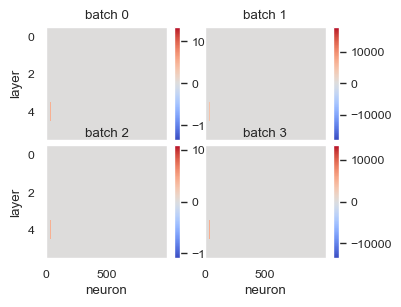

torch.Size([6, 32000])


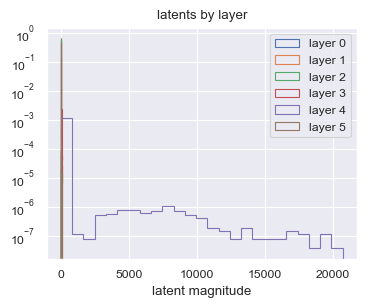

In [738]:
# visualize latent space
from matplotlib import cm


def plot_latent(latent):
    # plot image of latent space 
    vmax = latent.abs().max()
    for i in range(4): # first 4 batches
        plt.subplot(2, 2, i + 1)
        vmax = latent[i].max()
        plt.imshow(
            latent[i],
            cmap=cm.coolwarm,
            interpolation="none",
            aspect="auto",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.title(f"batch {i}")
        plt.ylabel("layer")
        plt.xlabel("neuron")
        if i < 2:
            plt.xlabel("")
            plt.xticks([])
        if i % 2 == 1:
            plt.ylabel("")
            plt.yticks([])
        plt.grid(False)
        plt.colorbar()
    # plt.colorbar()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

    # histogram
    latentf = rearrange(latent, "b l n -> (b n) l").T#.flatten()
    print(latentf.shape)
    for i in range(latent.shape[1]):
        plt.hist(latentf[i], bins=25,
                histtype="step", log=True, label=f"layer {i}", density=True)
    plt.title("latents by layer")
    plt.xlabel('latent magnitude')
    plt.legend()
    plt.show()

plot_latent(latent)

In [735]:
latent.shape

torch.Size([32, 6, 1000])

In [ ]:
from src.helpers.lightning import read_metrics_csv, plot_hist, rename_pl_test_results
from lightning.pytorch.callbacks import LearningRateMonitor

# Model

In [638]:
# from sparse_autoencoder.autoencoder.model import SparseAutoencoderConfig, SparseAutoencoder
from src.vae.sae2 import AutoEncoder, AutoEncoderConfig
from src.vae.conv_inception import (
    LinBnDrop,
    PLBase,
    recursive_requires_grad,
    accuracy,
    auroc,
)

In [639]:
class PLAE(PLBase):
    def __init__(
        self,
        c_in,
        steps_per_epoch,
        max_epochs,
        # depth=0,
        lr=4e-3,
        weight_decay=1e-9,
        # hs=64,
        n_latent=32,
        l1_coeff=1,
        dropout=0,
        encoder_sizes=[],
        importance_matrix=None,
        **kwargs,
    ):
        super().__init__(
            steps_per_epoch=steps_per_epoch,
            max_epochs=max_epochs,
            lr=lr,
            weight_decay=weight_decay,
        )
        self.save_hyperparameters()
        self.importance_matrix = importance_matrix
        expansion_factor = 2

        n_layers, n_channels = c_in
        self.ae_cfg = AutoEncoderConfig(
            n_instances=n_layers,
            n_input_ae=n_channels,
            n_hidden_ae=n_latent,
            l1_coeff=l1_coeff,
            encoder_sizes=encoder_sizes,
        )

        self.ae = AutoEncoder(
            self.ae_cfg,
            importance_matrix=importance_matrix,
        )

        n = n_latent * n_layers
        self.head = nn.Sequential(
            # LinBnDrop(n, n, bn=False, dropout=dropout),
            # LinBnDrop(n, n // 4, dropout=dropout, bn=False),
            # LinBnDrop(n // 4, n // 12, bn=False),
            nn.Linear(n, 1),
        )
        self._ae_mode = True

    def ae_mode(self, mode=0):
        """
        mode 0, train the ae
        mode 1, train only the prob
        mode 2, train both
        """
        if mode == 0:
            print("training ae")
        elif mode == 1:
            print("training probe")
        elif mode == 2:
            print("training both ae and probe")
        self._ae_mode = mode
        recursive_requires_grad(self.ae, mode in [0, 2])

    def forward(self, x):
        if x.ndim == 4:
            x = x.squeeze(3)

        # x = rearrange(x, "b l h -> b h l")
        # if not self._ae_mode:
        #     with torch.no_grad():
        #         l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)
        # else:
        # l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)

        # latent, h_rec = self.ae(x)
        loss, latent, h_rec, info = self.ae(x)
        # l1_loss, l2_loss, loss = self.ae.losses(latent, h_rec)
        # h_err = h_rec - x
        # if self.importance_matrix is not None:
        #     importance_matrix = self.importance_matrix[None, : ].to(h_err.device)
        #     h_err = h_err * importance_matrix
        # # for some reason in the https://github.dev/ai-safety-foundation/sparse_autoencoder repo
        # # they do sum over latent, mean over features, which is confusing because then l1_coeff will vary with different model sizes
        # l2_loss = h_err.pow(2).mean(2).mean(1) # shape [batch_size n_instances features]
        # l1_loss = latent.abs().sum(2).mean(1) # shape [batch_size n_instances n_latent]
        # loss = (self.hparams.l1_coeff * l1_loss + l2_loss).mean(0) # scalar

        latent2 = rearrange(latent, "b l h -> b (l h)")
        pred = self.head(latent2).squeeze(1)
        return dict(
            pred=pred,
            loss=loss,
            latent=latent,
            h_rec=h_rec,
            **info
        )

    # def on_after_backward(self):
    #     self.ae.post_backwards_hook()

    def _step(self, batch, batch_idx, stage="train"):
        device = next(self.parameters()).device
        if stage == "train":
            self.ae.normalize_decoder()
        x, y = batch  # batch['X'], batch['y']
        x = x.to(device)
        y = y.to(device)
        x0 = x  # [..., 0]
        # x1 = x[..., 1]
        info0 = self(x0)
        # info1 = self(x1)
        # ypred1 = info1["pred"]
        logits = info0["pred"]
        y_probs = F.sigmoid(logits)
        y_cls = y_probs > 0.5

        if stage == "pred":
            return (y_probs).float()

        pred_loss = F.binary_cross_entropy_with_logits(logits, (y > 0.0).float())

        # pred_loss = F.smooth_l1_loss(ypred0, y)
        rec_loss = info0["loss"]
        l1_loss = info0["l1_loss"].mean()
        l2_loss = info0["l2_loss"].mean()

        if self._ae_mode in [1, 2]:
            self.log(
                f"{stage}/auroc",
                auroc(y_probs, y > 0, "binary"),
                on_epoch=True,
                on_step=False,
            )
            self.log(
                f"{stage}/acc",
                accuracy(y_cls, y > 0, "binary"),
                on_epoch=True,
                on_step=False,
            )
            self.log(
                f"{stage}/loss_pred",
                float(pred_loss),
                on_epoch=True,
                on_step=True,
            )
        if self._ae_mode in [0, 2]:
            self.log(
                f"{stage}/loss_rec",
                float(rec_loss),
                on_epoch=True,
                on_step=True,
            )
            self.log(f"{stage}/l1_loss", l1_loss, on_epoch=True, on_step=False)
            self.log(f"{stage}/l2_loss", l2_loss, on_epoch=True, on_step=False)
        self.log(
            f"{stage}/n",
            float(len(y)),
            on_epoch=True,
            on_step=False,
            reduce_fx=torch.sum,
        )
        
        if self._ae_mode == 0:
            assert torch.isfinite(rec_loss), "rec_loss is not finite"
            return rec_loss
        elif self._ae_mode == 1:
            assert torch.isfinite(pred_loss), "pred_loss is not finite"
            return pred_loss
        elif self._ae_mode == 2:
            # , train/loss_pred_epoch=0.0195, train/loss_rec_epoch=169.0
            assert torch.isfinite(pred_loss), "pred_loss is not finite"
            assert torch.isfinite(rec_loss), "rec_loss is not finite"
            return pred_loss * 50000 + rec_loss

# Train

### Setup

In [640]:
print(len(dl_train), len(dl_val))
b = next(iter(dl_train))
x, y = b  # b['X'], b['y']
print(x.shape, "x")
if x.ndim == 3:
    x = x.unsqueeze(-1)
c_in = x.shape[1:-1]

10 5
torch.Size([32, 6, 17920]) x


In [641]:
# # TEST
# for b in tqdm(dl_train):
#     pass

In [642]:
# %%time
# # oh no, this is very slow
# g = iter(dl_train)
# b = next(g)
# b = next(g)


In [643]:
# cfg.depth = 4

# hidden_sizes = np.logspace(np.log10(cfg.n_input_ae), np.log10(cfg.n_hidden_ae), cfg.depth).astype(int)

In [644]:
# cfg = net.ae_cfg
# n_in = cfg.n_input_ae

# hidden_sizes = np.logspace(np.log10(cfg.n_input_ae), np.log10(cfg.n_hidden_ae), cfg.depth).astype(int)

# for i in range(len(hidden_sizes)-1):
#     print(hidden_sizes[i], hidden_sizes[i+1])


# # self.encoder = nn.Sequential(*self.encoder)
# print('next')
# # self.decoder = []
# hidden_sizes2 = hidden_sizes[::-1]
# for i in range(len(hidden_sizes)-1):
#     print(hidden_sizes2[i], hidden_sizes2[i+1])

In [709]:
l1_coeff = 1e-3

In [710]:
net = PLAE(
    c_in=c_in,
    steps_per_epoch=len(dl_train),
    max_epochs=max_epochs,
    lr=lr,
    encoder_sizes=[128,],
    weight_decay=wd,
    # hs=64,
    # dropout=0.3,
    n_latent=1000,  # there will be layers * n_latent latent features
    l1_coeff=l1_coeff,
    importance_matrix=importance_matrix,
)
print(net)

PLAE(
  (ae): AutoEncoder(
    (norm): Affines(
      (affines): ModuleList(
        (0-5): 6 x AffineInstanceNorm1d(17920, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
    )
    (encoder): Sequential(
      (0): NormedLinears(
        (linears): ModuleList(
          (0-5): 6 x NormedLinear(in_features=17920, out_features=128, bias=False)
        )
        (act): ReLU()
      )
      (1): NormedLinears(
        (linears): ModuleList(
          (0-5): 6 x NormedLinear(in_features=128, out_features=1000, bias=False)
        )
        (act): ReLU()
      )
    )
    (decoder): Sequential(
      (0): NormedLinears(
        (linears): ModuleList(
          (0-5): 6 x NormedLinear(in_features=1000, out_features=128, bias=False)
        )
        (act): ReLU()
      )
      (1): NormedLinears(
        (linears): ModuleList(
          (0-5): 6 x NormedLinear(in_features=128, out_features=17920, bias=True)
        )
      )
    )
  )
  (head): Sequential(
    (0): L

In [711]:
print(c_in)
x1 = x[..., 0]
with torch.no_grad():
    y = net(x1)
# {k: v.abs().mean() for k, v in y.items()}, {k: v.shape for k, v in y.items()}
# y

torch.Size([6, 17920])


In [712]:
from torchinfo import summary

summary(net, input_data=x1, depth=4, col_names=("input_size", "output_size", "num_params",))  # input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
PLAE                                               [32, 6, 17920]            [2]                       --
├─AutoEncoder: 1-1                                 [32, 6, 17920]            --                        --
│    └─Affines: 2-1                                [32, 6, 17920]            [32, 6, 17920]            --
│    │    └─ModuleList: 3-1                        --                        --                        --
│    │    │    └─AffineInstanceNorm1d: 4-1         [32, 17920]               [32, 17920]               --
│    │    │    └─AffineInstanceNorm1d: 4-2         [32, 17920]               [32, 17920]               --
│    │    │    └─AffineInstanceNorm1d: 4-3         [32, 17920]               [32, 17920]               --
│    │    │    └─AffineInstanceNorm1d: 4-4         [32, 17920]               [32, 17920]               --
│    │    │    └─AffineInstanceNorm1d: 4-

### Train autoencoder

In [713]:
torch.set_float32_matmul_precision("medium")

In [714]:
# with torch.no_grad():
#     o = net.predict_step(b)
#     l1_loss, l2_loss, loss, acts, h_reconstructed = net.ae(b[0])
#     # l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type        | Params
-------------------------------------
0 | ae   | AutoEncoder | 29.2 M
1 | head | Sequential  | 6.0 K 
-------------------------------------
29.2 M    Trainable params
0         Non-trainable params
29.2 M    Total params
116.699   Total estimated model params size (MB)


training ae
requires_grad: True


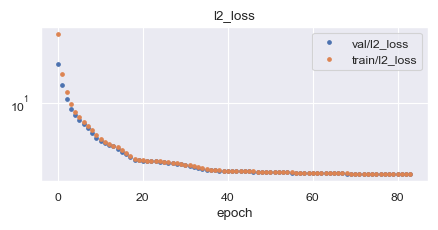

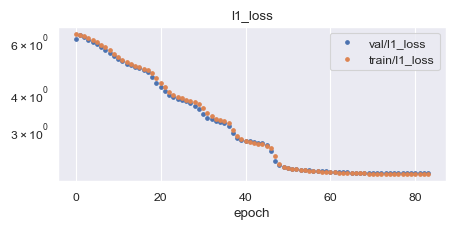

,step,train/loss_rec_step,val/loss_rec_step,val/n,val/l1_loss,val/loss_rec_epoch,val/l2_loss,train/l2_loss,train/loss_rec_epoch,train/n,train/l1_loss
epoch,,,,,,,,,,,
0.0,9,26.599184,24.087498,154.0,6.097120,24.082590,24.076492,47.088310,47.094669,307.0,6.359687
1.0,19,14.932219,14.749355,154.0,6.300547,14.731000,14.724700,19.065340,19.071665,307.0,6.325684
2.0,29,10.998047,10.755546,154.0,6.202061,10.763645,10.757443,12.683869,12.690132,307.0,6.262958
3.0,39,8.869331,8.703538,154.0,6.085141,8.708499,8.702414,9.779464,9.785625,307.0,6.158757
4.0,49,7.635508,7.559021,154.0,5.986299,7.557144,7.551158,8.151342,8.157404,307.0,6.060666
...,...,...,...,...,...,...,...,...,...,...,...
79.0,799,2.005919,2.006142,154.0,2.152010,2.006118,2.003966,2.004035,2.006176,307.0,2.141810
80.0,809,2.005419,2.005786,154.0,2.151923,2.005720,2.003568,2.003772,2.005914,307.0,2.141704
81.0,819,2.004824,2.005470,154.0,2.151891,2.005421,2.003269,2.003227,2.005369,307.0,2.141643


In [715]:
net.ae_mode(0)
trainer1 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    accelerator="auto",
    devices="1",
    max_epochs=max_epochs,  # * VAE_EPOCH_MULT,
    log_every_n_steps=1,
    enable_progress_bar=verbose,
    # enable_model_summary=verbose,
)

# LOAD_CHECKPONT = Path('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_52/1_ae.ckpt')
LOAD_CHECKPONT = None
if LOAD_CHECKPONT:
    PLAE.load_from_checkpoint(LOAD_CHECKPONT)
else:
    trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
    df_hist, df_hist_step = read_metrics_csv(
        trainer1.logger.experiment.metrics_file_path
    )
    plot_hist(df_hist, ["l2_loss", "l1_loss", "loss_rec"], logy=True)
    # plt.show()
    # plot_hist(df_hist_step, ['loss_rec_step'], logy=True)

    display(df_hist)

In [716]:
# def calc_hoyer(x):
#     """
#     https://github.com/yanghr/DeepHoyer
#     """
#     a = x.pow(2).sum(1).sqrt().sum() 
#     b = x.pow(2).sum(2).sqrt().sum()
#     d = x.pow(2).sum().sqrt()
#     print(a.sum(), b.sum(), d)
#     return (a+b)/d


# calc_hoyer(latent), calc_hoyer(y['h_rec']-x1)
# # latent.shape

In [717]:
# plot_hist(df_hist, ['l2_loss', 'l1_loss', 'loss_rec'], logy=False)

In [718]:
df_hist, df_hist_step = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)

In [719]:
# DEBUG: Check the LR
# df_hist['lr-AdamW'].plot()

In [720]:
# DEBUG check the decoder is still unit norm weights
w = net.ae.decoder[0].linears[2].weight
# assert w.norm(dim=0).mean().round(2)==1
np.testing.assert_almost_equal(w.norm(dim=0).mean().detach().cpu(), 1, decimal=2)

In [721]:
# df_hist[['train/l2_loss','train/l1_loss']]

In [722]:
ratio = df_hist["train/l2_loss"] / df_hist["train/l1_loss"]
ratio = ratio[np.isfinite(ratio)]
print(f"l1 coeff should be approx {ratio.mean()/l1_coeff} but is {l1_coeff}")


# print(f"% of latent is empty {((latent>0)*1.0).mean()}")

l1 coeff should be approx 972.2897081117 but is 0.001


In [723]:
rs3r = trainer1.test(
    net, dataloaders=[dl_train, dl_val, dl_test, dl_ood], verbose=False
)
rs3 = rename_pl_test_results(rs3r, ["train", "val", "test", "ood"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


|                |   train |     val |    test |     ood |
|:---------------|--------:|--------:|--------:|--------:|
| loss_rec_epoch |   2.005 |   2.005 |   2.005 |   2.005 |
| l1_loss        |   2.138 |   2.152 |   2.143 |   2.143 |
| l2_loss        |   2.003 |   2.003 |   2.003 |   2.003 |
| n              | 307     | 154     | 154     | 615     |


#### QC

QC: view latent


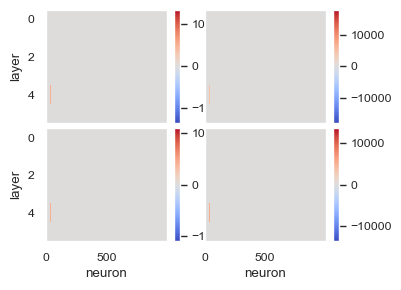

torch.Size([6, 32000])


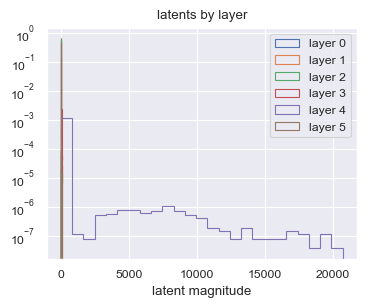

In [724]:
x1 = x[..., 0]
with torch.no_grad():
    y = net(x1)

print('QC: view latent')
latent = y["latent"].cpu()  # .reshape(64, 24, 12) # [Batch, Latent, Layer]
plot_latent(latent)

In [725]:
latent.shape, latent.diff(dim=1).std(), latent.std(), latent.diff(dim=2).std(), 16 * 7

(torch.Size([32, 6, 1000]),
 tensor(452.5368),
 tensor(292.5023),
 tensor(414.1008),
 112)

In [726]:

sparsity = ((latent > 0) * 1.0).mean()
print(f'QC: latent usage {sparsity:2.2%}')


sparsity_mult = y['l1_losses']/y['l1_raw']
print(f'QC: sparsity multiplier per layer {sparsity_mult.mean(0)}')

QC: latent usage 19.12%
QC: sparsity multiplier per layer 0.625


mean by layertensor([ 0.2954,  0.3514,  0.3442,  9.7103, 52.7869,  0.2855])
usage by layertensor([0.1695, 0.1936, 0.1711, 0.4414, 0.0116, 0.1600])


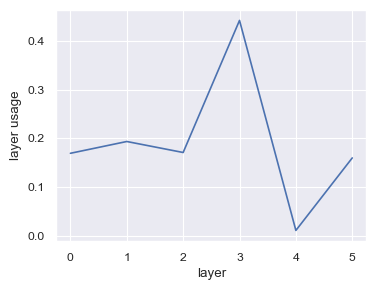

In [727]:
print(f"mean by layer{latent.mean(dim=0).mean(-1)}")
print(f"usage by layer{((latent>0)*1.0).mean(dim=0).mean(-1)}")

plt.plot(((latent>0)*1.0).mean(dim=0).mean(-1))
plt.ylabel('layer usage')
plt.xlabel('layer')
plt.show()

tensor([4.2696, 3.2449])

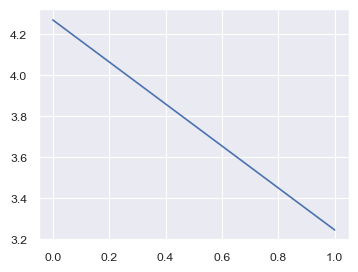

In [728]:
# DEBUG:  l1_loss by layer. should be lower in the middle?
plt.plot(y['l1_raw'])
y['l1_raw']

### Train probe

In [729]:
net.ae_mode(1)
trainer2 = pl.Trainer(
    # precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=1,
    enable_progress_bar=verbose,
    enable_model_summary=verbose,
    # callbacks=[lr_logger],
)
trainer2.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


training probe
requires_grad: False


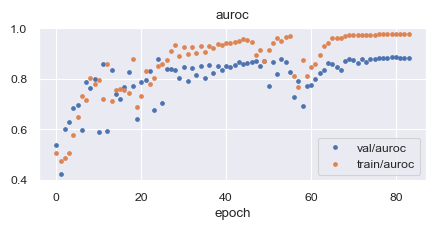

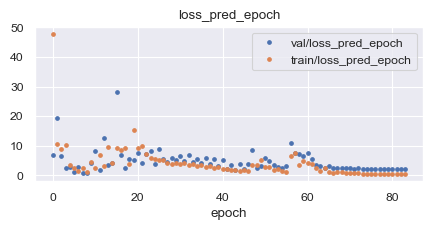

,train/loss_pred_step,step,val/loss_pred_step,val/n,val/acc,val/auroc,val/loss_pred_epoch,train/n,train/acc,train/auroc,train/loss_pred_epoch
epoch,,,,,,,,,,,
0.0,11.014874,9,7.969140,154.0,0.474026,0.538393,6.773554,307.0,0.384365,0.507526,47.815769
1.0,21.861101,19,14.099693,154.0,0.512987,0.423701,19.186268,307.0,0.557003,0.476648,10.426188
2.0,3.613168,29,7.887321,154.0,0.480519,0.601321,6.597212,307.0,0.579805,0.487863,8.686114
3.0,2.208763,39,2.067283,154.0,0.597403,0.630560,2.500106,307.0,0.390879,0.505910,10.270950
4.0,3.393924,49,3.044225,154.0,0.545455,0.685807,2.624301,307.0,0.527687,0.576080,3.441249
...,...,...,...,...,...,...,...,...,...,...,...
79.0,0.002036,799,2.103490,154.0,0.805195,0.885117,2.010596,307.0,0.918567,0.976120,0.409824
80.0,0.001593,809,2.107821,154.0,0.805195,0.885385,2.010914,307.0,0.912052,0.977816,0.413743
81.0,0.002873,819,2.145453,154.0,0.805195,0.884440,2.020046,307.0,0.908795,0.976534,0.414278


In [730]:
df_hist, _ = read_metrics_csv(trainer2.logger.experiment.metrics_file_path)
plot_hist(df_hist, ["loss_pred_epoch", "auroc"])
df_hist

In [731]:
rs3r = trainer2.test(
    net, dataloaders=[dl_train, dl_val, dl_test, dl_ood], verbose=False
)
rs3 = rename_pl_test_results(rs3r, ["train", "val", "test", "ood"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


|                 |   train |     val |    test |     ood |
|:----------------|--------:|--------:|--------:|--------:|
| auroc           |   0.968 |   0.884 |   0.902 |   0.935 |
| acc             |   0.906 |   0.805 |   0.799 |   0.854 |
| loss_pred_epoch |   0.575 |   2.024 |   1.797 |   1.244 |
| n               | 307     | 154     | 154     | 615     |


In [732]:
a = calc_metrics(dm, net, split="test", verbose=False)
b = calc_metrics(dm, net, split="val", verbose=False)
c = calc_metrics(dm_ood, net, split="all", verbose=False)
df_metrics = pd.DataFrame([a, b, c], index=["test", "val", "ood"]).iloc[:, :3]
print(df_metrics.round(2).to_markdown())
df_metrics

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]




probe accuracy for quadrants:
| instructed to   |   did |   didn't |
|:----------------|------:|---------:|
| tell a truth    |  0.89 |     0.57 |
| tell a lie      |  0.62 |     0.81 |





LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]




probe accuracy for quadrants:
| instructed to   |   did |   didn't |
|:----------------|------:|---------:|
| tell a truth    |  0.82 |     0.79 |
| tell a lie      |  0.67 |     0.75 |





probe accuracy for quadrants:
| instructed to   |   did |   didn't |
|:----------------|------:|---------:|
| tell a truth    |  0.89 |     0.77 |
| tell a lie      |  0.7  |     0.87 |



|      |   acc |   acc_lie_lie |   acc_lie_truth |
|:-----|------:|--------------:|----------------:|
| test |  0.8  |          0.62 |            0.81 |
| val  |  0.81 |          0.67 |            0.75 |
| ood  |  0.85 |          0.7  |            0.87 |


,acc,acc_lie_lie,acc_lie_truth
test,0.798701,0.625000,0.807692
val,0.805195,0.666667,0.750000
ood,0.853659,0.700000,0.866667


### Train end-to-end


In [733]:
1 / 0

ZeroDivisionError: division by zero

In [ ]:
net.ae_mode(2)
trainer3 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False, enable_model_summary=False
)
trainer3.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
1

In [ ]:
# ds2df(dm.dm_orig)


In [ ]:
# look at hist
df_hist, _ = read_metrics_csv(trainer3.logger.experiment.metrics_file_path)
plot_hist(df_hist, ["loss_pred", "acc"])

rs3r = trainer3.test(
    net, dataloaders=[dl_train, dl_val, dl_test, dl_ood], verbose=False
)
rs3 = rename_pl_test_results(rs3r, ["train", "val", "test", "ood"])

# predict
a = calc_metrics(dm, net, trainer1, "test")
b = calc_metrics(dm, net, trainer1, "val")
pd.DataFrame([a, b], index=["test", "val"])

c = calc_metrics(dm_ood, net, trainer1, "all")
pd.DataFrame([a, b, c], index=["test", "val", "ood"])

In [ ]:
a = calc_metrics(dm, net, trainer1, "test")
b = calc_metrics(dm, net, trainer1, "val")
c = calc_metrics(dm_ood, net, trainer1, "all")
df_metrics = pd.DataFrame([a, b, c], index=["test", "val", "ood"]).iloc[:, :3]
print(df_metrics.round(3).to_markdown())
df_metrics